17장 블로킹 I/O와 GIL 

In [2]:
from IPython.display import Image

Cython 인터프리터는 내부적으로 Global Interpreter Lock을 갖고 있다. GIL은 한 번에 한 스레드만 파이썬코드를 실행하도록 제한한다. 
때문에 단일 파이썬 프로세스가 동시에 다중 CPU코어를 사용할 수 없다.

CPython에서의 GIL은 Python 코드(bytecode)를 실행할 때에 여러 thread를 사용할 경우, 단 하나의 thread만이 Python object에 접근할 수 있도록 제한하는 mutex 이다. 그리고 이 lock이 필요한 이유는 CPython이 메모리를 관리하는 방법이 thread-safe하지 않기 때문이다

## Process 와 Thread 

운영체제가 생성하는 작업 단위를 process라고 한다. 이 process안에서 공유되는 메모리를 바탕으로 여러 작업을 또 생성할 수가 있는데, 이때 작업 단위를 Thread라고 한다. 따라서 각 Thread마다 할당된 개인적인 메모리가 있으면서, Thread가 속한 process가 가지는 메모리에도 접근할 수 있다.

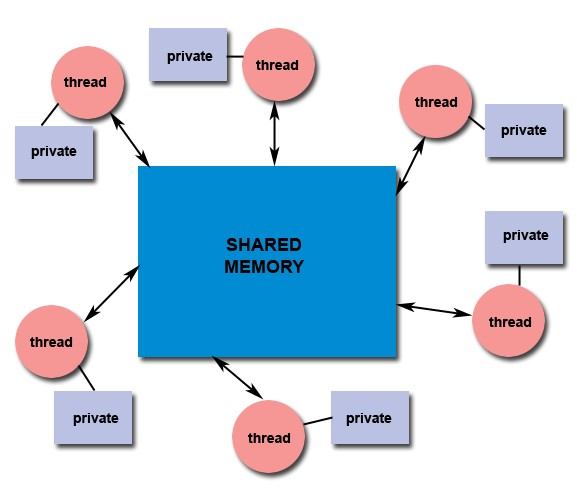

In [3]:
Image('shared_memory.jpg')

## Thread-safeness

"Thread-safe하지 않다"는 것은 무슨 의미인지부터 알아보겠다. 위에서 thread들은 process가 공유하는 메모리에 접근할 수 있다고 언급했었는데, 이로 인해 참사가 발생할 수 있다. 이번엔 Python 코드 예제를 통해 참사를 경험해보자

In [ ]:
import threading x = 0
def foo(): 
    global x 
    for i in range(100000000):
        x += 1 

def bar(): 
    global x 
    for i in range(100000000):
        x -= 1 
        
t1 = threading.Thread(target=foo) 
t2 = threading.Thread(target=bar) 
t1.start() 
t2.start() 
t1.join() 
t2.join() 
print(x)

print(x)의 결과가 0으로 나오는 게 내가 생각하기엔 정상적으로 작동한 것이리라 생각이 든다. 하지만 실제 계산을 해보면 x의 값은 전혀 이상한 숫자가 된다. 왜 그럴까? 전역 변수 x에 두 개의 thread가 동시에 접근해서 각자의 작업을 하면서 어느 한 쪽의 작업 결과가 반영이 되지 않기 때문이다 ("씹혔다"라고 표현할 수도 있겠다). 이렇게 여러 thread가 공유된 데이터를 변경함으로써 발생하는 문제를 race condition이라고도 부른다. 



## Mutex란?

Thread-safe한 코드를 만들기 위해서 사용하는 것 중 하나가 mutex (mutual exclusion)이다. 위에서 본 참사를 막기 위해서, 공유되는 메모리의 데이터를 여러 thread가 동시에 사용할 수 없도록 잠그는 일을 mutex가 맡는다.

Stackoverflow에서 찾은 mutex에 대한 굉장히 좋은 비유를 여기에 우리 말로 옮겨놓는다.

>휴대폰이 없던 시절에는 공중 전화를 주로 이용했었다. 거리의 모든 남자들은 각자의 아내에게 전화를 너무나 걸고 싶어한다.<br>
어떤 한 남자가 처음으로 공중 전화 부스에 들어가서 그의 사랑하는 아내에게 전화를 걸었다면, 그는 꼭 전화 부스의 문을 꼭 잡고 있어야 한다. 왜냐하면 사랑에 눈이 먼 다른 남자들이 전화를 걸기 위해 시도때도 없이 달려들고 있기 때문이다. 줄 서는 질서 문화 따위는 없다. 심지어 그 문을 놓친다면, 전화 부스에 들이닥친 남자들이 수화기를 뺏어 당신의 아내에게 애정 표현을 할 지도 모른다.<br>
아내와의 즐거운 통화를 무사히 마쳤다면, 이제 문을 잡고 있던 손을 놓고 부스 밖으로 나가면 된다. 그러면 공중 전화를 쓰기 위해 달려드는 다른 남자들 중 제일 빠른 한 명이 부스에 들어가서 똑같이 문을 꼭 잡고 그의 아내와 통화할 수 있다.

이 재밌는 이야기를 아래와 같이 thread 개념에 하나씩 대응시킬 수 있다.

- thread: 각 남자들
- mutex: 공중 전화 부스의 문
- lock: 그 문을 잡고 있는 남자의 손
- resource: 공중 전화

1) C언어의 메모리 관리

>어느 한 thread가 최초로 mutex를 가져갔다면 (pthread_mutex_lock을 성공했다면), 그 thread는 그 다음 코드를 계속 진행할 수 있다. 반면, 그 순간 이후로 다른 thread가 mutex를 가져가려고 한다면, 첫 번째로 mutex를 가져간 thread가 그 잠금을 풀 때까지 (pthread_mutex_unlock를 실행할 때까지) 기다려야 한다. 그렇게 mutex의 잠금이 해제되면, 이제서야 두 번째 thread가 mutex를 받아서 다음 코드를 진행할 수 있게 된다.,<br>
>이렇게 mutex가 보호하고자 하는 변수는 dotstr.sum으로, thread들이 각자의 합을 계산해서 모두 합치는 자리인데, 여기서 race condition이 발생한다면 제대로 총합이 더해질 수 없기 때문에, mutex를 이용해서 이 변수에 동시적인 접근을 막는 것이다.

2) CPython의 메모리 관리

>reference의 개수를 세는 방법으로 메모리를 관리한다. sys.getrefcount라는 함수를 이용해서 Python이 세고 있는 object의 reference 개수를 확인할 수 있다.


## 다시, GIL
지금까지 알아본 것들을 헤아려 보면 크게 두 가지다.

C에서 thread를 사용할 때에 race condition이 일어나지 않도록 하는 것은 순전히 사용자의 몫이다.<br>
CPython은 생성되는 개체의 reference를 세어가면서 메모리 관리를 한다.<br>
그러므로 우리는 자연스럽게 CPython이 reference counting을 하는 과정에서의 대참사가 일어날 수 있음을 생각해볼 수 있다. Reference counting 중에 race condition이 일어난다면, 그 결과는 결국 메모리 유실 (memory leak)일 것이다 (반대로 아직 살아있어야 할 object를 죽여버릴 수도 있다).

이를 해결하기 위해서는 mutex를 이용하면 된다고 언급했었다. 위에서 봤던 예제처럼 생각해보자면, ob_refcnt 변수를 바꾸는 지점에서 mutex를 잠가야 될 것 같다. 그러면 object 하나 하나마다에 대응하는 mutex가 필요하게 된다. 여러 개의 mutex를 사용하는 것은 성능적으로도 많은 손해를 볼 뿐 아니라, deadlock이라는 치명적인 위험 상황을 불러들이게 되어 좋지 않은 결정이 된다

CPython의 결정은 이렇다. mutex를 통해 모든 reference 개수를 일일이 보호하지 말고, Python interpreter 자체를 잠그기로 한 것이다. 이거 하나만 mutex로 보호하면 그동안 우려했던 문제를 해결할 수 있다. 하지만, 얼마나 많은 thread를 사용하던지에 상관없이 오직 한 thread만이 Python code를 실행할 수 있다는 의미이기도 하다. 사실상 한 process 안에서 여러 thread를 이용한 병렬 처리를 막은 것이라고 생각할 수도 있겠다. 한 thread가 Python bytecode를 실행하기 위해서는 공중 전화 부스에 들어가서 interpreter lock을 잡아야 하는 것이다.

그래서 Global Interpreter Lock이다.


## 마치며
기본적인 Python 사용자 입장에서 GIL로 인해 불편을 느낄 가능성은 거의 없다.

일단 단일 thread일 때는 아무런 문제가 없다.
CPU가 바쁘게 계산하는 일들은 numpy/scipy에서 GIL 바깥에서 굉장히 효율적인 C 코드로 연산할 수 있다.
병렬 처리에 관해서는 굳이 thread가 아니더라도 multiprocessing이나 asyncio 등의 많은 선택지가 있다.
굳이 thread 간의 동시적인 처리가 필요하다면 다른 Python implementation을 고려해봐도 된다. Jython, IronPython, Stackless Python, PyPy 등이 있다.
하지만 기본적으로 CPython이 내부적으로 어떤 역사가 있는 지를 아는 것만으로도 충분히 의미있다고 생각한다. 또한 당신이 CPython API를 이용한 C extension을 작성하고자 한다면, Python이 메모리를 관리하는 방식과 GIL의 존재를 모르고는 할 수 없을 것이다.